In [1]:
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import os, subprocess


#Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

################################################################
#ONLY THIS NEEDS TO BE CHANGED:
#select the Date

#Date = '2017_09_05'
#Date = '2018_05_04'
#Date = '2018_05_23'
#Date = '2018_06_12'
#Date = '2018_08_21'
Date = '2018_10_10'


#The target resoution (pixel size)
target_xres = 0.2
target_xres = 0.2

#The current working Directory 
workingDirectory = '/home/alex/Dokumente/Wetscapes/Data/' + Date
os.chdir(workingDirectory)
print "Directory changed to", str(workingDirectory)
################################################################

#create the directory 'Processed'
if not os.path.exists('Processed'):
    os.makedirs('Processed')

#input
rgb_in = '01_RGB/'+ Date + '_pw_rgb_transparent_mosaic_group1.tif'
dsm_in = '02_DSM/'+ Date + '_pw_rgb_dsm.tif'
ms_in  = '03_MS/'+ Date + '_PW_MS_stack.tif'
th_in  = '04_THERMAL/'+ Date + '_pw_th_index_temperature_georef.tif'
mask   = '/home/alex/Dokumente/Wetscapes/Data/Mask/Mask.shp'

#output
if os.path.exists('Processed/'+ Date + '_stack.tif'):
    os.remove('Processed/'+ Date + '_stack.tif')

stack   = 'Processed/'+ Date + '_stack.tif'

#read the input
rgb  = gdal.Open(rgb_in, gdal.GA_ReadOnly)
ms   = gdal.Open(ms_in, gdal.GA_ReadOnly)
dsm  = gdal.Open(dsm_in, gdal.GA_ReadOnly)
th   = gdal.Open(th_in, gdal.GA_ReadOnly)



Directory changed to /home/alex/Dokumente/Wetscapes/Data/2018_10_10


In [2]:
#Get the raster size
xmax = rgb.RasterXSize
ymax = rgb.RasterYSize
#Get the pixel size
gt = rgb.GetGeoTransform()
pixelSizeX = gt[1]
pixelSizeY =-gt[5]

print 'rgb is sized:\t', str(xmax), '*', str(ymax), '\tPixelsize is:\t', pixelSizeX, '*', pixelSizeY

xmax = ms.RasterXSize
ymax = ms.RasterYSize
gt = ms.GetGeoTransform()
pixelSizeX = gt[1]
pixelSizeY =-gt[5]

print 'ms is sized:\t', str(xmax), '*', str(ymax), '\tPixelsize is:\t', pixelSizeX, '*', pixelSizeY

xmax = dsm.RasterXSize
ymax = dsm.RasterYSize
gt = dsm.GetGeoTransform()
pixelSizeX = gt[1]
pixelSizeY =-gt[5]

print 'dsm is sized:\t', str(xmax), '*', str(ymax), '\tPixelsize is:\t', pixelSizeX, '*', pixelSizeY

xmax = th.RasterXSize
ymax = th.RasterYSize
gt = th.GetGeoTransform()
pixelSizeX = gt[1]
pixelSizeY =-gt[5]

print 'th is sized:\t', str(xmax), '*', str(ymax), '\tPixelsize is:\t', pixelSizeX, '*', pixelSizeY

rgb is sized:	26237 * 16029 	Pixelsize is:	0.02094 * 0.02094
ms is sized:	6144 * 4013 	Pixelsize is:	0.09644 * 0.09644
dsm is sized:	26237 * 16029 	Pixelsize is:	0.02094 * 0.02094
th is sized:	3691 * 2111 	Pixelsize is:	0.191826480593 * 0.191826480593


In [3]:
#Erase the 4. band (=alpha band) from rgb.tif
rgb_temp = 'Processed/rgb_temp.tif'
trans = gdal.Translate(rgb_temp, rgb, bandList = [1,2,3], outputType = gdal.GDT_Float32)
trans = None

#Crop the raster data with the mask
#And set the target resolution

rgb_cut = 'Processed/rgb_cut.tif'
dsm_cut = 'Processed/dsm_cut.tif'
ms_cut  = 'Processed/ms_cut.tif'
th_cut  = 'Processed/th_cut.tif'

warp = gdal.Warp(rgb_cut,
              rgb_temp,
              xRes = target_xres,
              yRes = target_xres,
              format = 'GTiff',
              cutlineDSName=mask,
              cropToCutline=True,
              dstNodata = 0)
os.remove("Processed/rgb_temp.tif") 
warp = None

warp = gdal.Warp(dsm_cut,
              dsm,
              xRes = target_xres,
              yRes = target_xres,
              format = 'GTiff',
              cutlineDSName=mask,
              cropToCutline=True,
              dstNodata = 0)
warp = None

warp = gdal.Warp(ms_cut,
              ms,
              xRes = target_xres,
              yRes = target_xres,
              format = 'GTiff',
              cutlineDSName=mask,
              cropToCutline=True,
              dstNodata = 0)
warp = None

warp = gdal.Warp(th_cut,
              th,
              xRes = target_xres,
              yRes = target_xres,
              format = 'GTiff',
              cutlineDSName=mask,
              cropToCutline=True,
              dstNodata = 0)
warp = None

In [4]:
#Raster Calculator
#https://gis.stackexchange.com/questions/268041/inserting-python-variables-into-gdal-calc-expression

#RGB (S.O.D.A.)
# Band1: Blau
# Band2: Grün
# Band3: Rot

#MS (Sequoia)
# Band 1: Grün(550)
# Band 2: Rot(660)
# Band 3: RE(735)
# Band 4: NIR (790)

#To Calculate
#10 GI      aus RGB (G)/(R+G+B)
#11 NDVI    aus MS  (NIR-RED)/(NIR+RED)
#12 reNDVI  aus MS  (NIR-RE)/(NIR+RE)
#13 reNDVI2 aus MS  (RE-RED)/(RE+RED)
#14 gNDVI   aus MS  (NIR-GREEN)/(NIR+GREEN)

#the output files
GI       = 'Processed/GI.tif'
NDVI     = 'Processed/NDVI.tif'
reNDVI   = 'Processed/reNDVI.tif'
reNDVI2  = 'Processed/reNDVI2.tif'
gNDVI    = 'Processed/gNDVI.tif'

#gdal_path = 'whatever/path/gdal/is/installed/at'
gdal_path = '/usr/bin'
gdal_calc_path = os.path.join(gdal_path, 'gdal_calc.py')

# Arguements.
RGB_file_path     = os.path.realpath(rgb_cut)
MS_file_path      = os.path.realpath(ms_cut)
DSM_file_path     = os.path.realpath(dsm_cut)
TH_file_path      = os.path.realpath(th_cut)
GI_file_path      = os.path.realpath(GI)
NDVI_file_path    = os.path.realpath(NDVI)
reNDVI_file_path  = os.path.realpath(reNDVI)
reNDVI2_file_path = os.path.realpath(reNDVI2)
gNDVI_file_path   = os.path.realpath(gNDVI)

nodata = '0'
typeof = '"Float32"'

#Calculate Expressions
GI_calc_expr      = '"B/(A+B+C)"'
NDVI_calc_expr    = '"(D-B)/(D+B)"'
reNDVI_calc_expr  = '"(D-C)/(D+C)"'
reNDVI2_calc_expr = '"(C-B)/(C+B)"'
gNDVI_calc_expr   = '"(D-A)/(D+A)"'

# Greenness Index (GI)
# Generate string of process.
gdal_calc_str = 'python {0} -A {1} --A_band=1 -B {1} --B_band=2 -C {1} --C_band=3 --outfile={2} --calc={3} --NoDataValue={4} --type={5} --overwrite'
gdal_calc_process = gdal_calc_str.format(
                                        gdal_calc_path, 
                                        RGB_file_path,
                                        GI_file_path, 
                                        GI_calc_expr, 
                                        nodata, 
                                        typeof)
os.system(gdal_calc_process)

# NDVI 
# Generate string of process.
gdal_calc_str = 'python {0} -B {1} --B_band=2 -D {1} --D_band=4 --outfile={2} --calc={3} --NoDataValue={4} --type={5} --overwrite'
gdal_calc_process = gdal_calc_str.format(
                                        gdal_calc_path, 
                                        MS_file_path,
                                        NDVI_file_path, 
                                        NDVI_calc_expr, 
                                        nodata, 
                                        typeof)
os.system(gdal_calc_process)

# reNDVI 
# Generate string of process.
gdal_calc_str = 'python {0} -C {1} --C_band=3 -D {1} --D_band=4 --outfile={2} --calc={3} --NoDataValue={4} --type={5} --overwrite'
gdal_calc_process = gdal_calc_str.format(
                                        gdal_calc_path, 
                                        MS_file_path,
                                        reNDVI_file_path, 
                                        reNDVI_calc_expr, 
                                        nodata, 
                                        typeof)
os.system(gdal_calc_process)

# reNDVI2
# Generate string of process.
gdal_calc_str = 'python {0} -B {1} --B_band=2 -C {1} --C_band=3 --outfile={2} --calc={3} --NoDataValue={4} --type={5} --overwrite'
gdal_calc_process = gdal_calc_str.format(
                                        gdal_calc_path, 
                                        MS_file_path,
                                        reNDVI2_file_path, 
                                        reNDVI2_calc_expr, 
                                        nodata, 
                                        typeof)
os.system(gdal_calc_process)

# gNDVI
# Generate string of process.
gdal_calc_str = 'python {0} -A {1} --A_band=1 -D {1} --D_band=4 --outfile={2} --calc={3} --NoDataValue={4} --type={5} --overwrite'
gdal_calc_process = gdal_calc_str.format(
                                        gdal_calc_path, 
                                        MS_file_path,
                                        gNDVI_file_path, 
                                        gNDVI_calc_expr, 
                                        nodata, 
                                        typeof)
os.system(gdal_calc_process)


0

In [5]:
#Create the stack with gdal_merge.py

#The paths to the (temporary) files, needed for the merge command
RGB_file_path     = os.path.realpath(rgb_cut)
MS_file_path      = os.path.realpath(ms_cut)
DSM_file_path     = os.path.realpath(dsm_cut)
TH_file_path      = os.path.realpath(th_cut)
GI_file_path      = os.path.realpath(GI)
NDVI_file_path    = os.path.realpath(NDVI)
reNDVI_file_path  = os.path.realpath(reNDVI)
reNDVI2_file_path = os.path.realpath(reNDVI2)
gNDVI_file_path   = os.path.realpath(gNDVI)
stack_path        = os.path.realpath(stack)

#Generate string of process
#gdal_merge.py must be found manualy (in this case it was at: /usr/bin/gdal_merge.py)
#With UInt16 the ms-bands are shown as null values, with Float32 it seems to work
merge_command = ["python /usr/bin/gdal_merge.py -separate -of GTiff -ot Float32 -o " + 
                stack_path + " " +
                RGB_file_path + " " +
                MS_file_path + " " +
                DSM_file_path + " " +
                TH_file_path + " " +
                GI_file_path + " " +
                NDVI_file_path + " " +
                reNDVI_file_path + " " +
                reNDVI2_file_path + " " +
                gNDVI_file_path
                ]

# Call process
subprocess.call(merge_command,shell=True)

# remove the temp data
os.remove("Processed/rgb_cut.tif")
os.remove("Processed/ms_cut.tif")
os.remove("Processed/dsm_cut.tif")
os.remove("Processed/th_cut.tif")
os.remove("Processed/GI.tif")
os.remove("Processed/NDVI.tif")
os.remove("Processed/reNDVI.tif")
os.remove("Processed/reNDVI2.tif")
os.remove("Processed/gNDVI.tif")



	Pixelsize of output stack is:	0.2 * 0.2


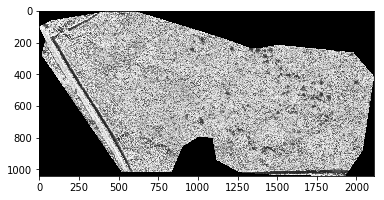

In [6]:
#show first Band of stack:
img_stack   = gdal.Open(stack, gdal.GA_ReadOnly)
img = img_stack.GetRasterBand(1).ReadAsArray().astype(np.uint8)
plt.imshow(img, cmap=plt.cm.Greys_r)

gt = img_stack.GetGeoTransform()
pixelSizeX = gt[1]
pixelSizeY =-gt[5]

print '\tPixelsize of output stack is:\t', pixelSizeX, '*', pixelSizeY